In [1]:
%matplotlib inline 

import os
import sys
sys.path.append(os.path.abspath('../src/'))

import pandas as pd
import numpy as np
import itertools 
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.plotting_context('paper')

from utils import *
from models import Net
from trainner import Trainner

from torchvision import transforms
import networkx as nx

In [2]:
subjects=['biology', 'cooking', 'crypto', 'diy', 'robotics', 'travel']
path2data = '../data/'
batch_size = 32

In [3]:
df = TextDataset(subjects, path2data + 'train/', is_train = True)

In [4]:
df.data.head()

,id,title,content,tags,subject
0,1,What is the criticality of the ribosome bindin...,"<p>In prokaryotic translation, how critical fo...",ribosome binding-sites translation synthetic-b...,biology
1,2,How is RNAse contamination in RNA based experi...,<p>Does anyone have any suggestions to prevent...,rna biochemistry,biology
2,3,Are lymphocyte sizes clustered in two groups?,<p>Tortora writes in <em>Principles of Anatomy...,immunology cell-biology hematology,biology
3,4,How long does antibiotic-dosed LB maintain goo...,<p>Various people in our lab will prepare a li...,cell-culture,biology
4,5,Is exon order always preserved in splicing?,<p>Are there any cases in which the splicing m...,splicing mrna spliceosome introns exons,biology


In [5]:
df.process_data()

In [6]:
df.data.head()

,id,title,content,tags,subject,data,tokens
0,1,What is the criticality of the ribosome bindin...,"In prokaryotic translation, how critical for e...",ribosome binding-sites translation synthetic-b...,biology,In prokaryotic translation critical efficient ...,"[In, prokaryotic, translation, ,, how, critica..."
1,2,How is RNAse contamination in RNA based experi...,Does anyone have any suggestions to prevent RN...,rna biochemistry,biology,Does anyone suggestions prevent RNAse contamin...,"[Does, anyone, have, any, suggestions, to, pre..."
2,3,Are lymphocyte sizes clustered in two groups?,Tortora writes in Principles of Anatomy and Ph...,immunology cell-biology hematology,biology,Tortora writes Principles Anatomy Physiology L...,"[Tortora, writes, in, Principles, of, Anatomy,..."
3,4,How long does antibiotic-dosed LB maintain goo...,Various people in our lab will prepare a liter...,cell-culture,biology,Various people lab prepare liter LB add kanamy...,"[Various, people, in, our, lab, will, prepare,..."
4,5,Is exon order always preserved in splicing?,Are there any cases in which the splicing mach...,splicing mrna spliceosome introns exons,biology,Are cases splicing machinery constructs mRNA e...,"[Are, there, any, cases, in, which, the, splic..."


In [7]:
words_lists = [t.strip().split() for t in df.data['data'].values]

In [8]:
def get_top_words(df, n=None):
    words = list(itertools.chain(*[t.strip().split() for t in df['data'].values]))
    top_words = collections.Counter(list(words)).most_common(n)
    words, count = zip(*top_words)
    return words, count

In [9]:
# Created DataFrame indexed on tags
words_df = pd.DataFrame(index=set(itertools.chain(*words_lists)))

In [10]:
# For each category create a column and update the flag to tag count
for i, (name, group) in enumerate(df.data.groupby('subject')):
    words_df[name] = 0
    tmp_index, count = get_top_words(group)
    tmp = pd.Series(count, index=tmp_index)
    words_df[name].update(tmp)

words_df['categories_appears'] = words_df.apply(lambda x: x.astype(bool).sum(), axis=1)

In [13]:
words_df.sort_values('categories_appears', ascending=False).head()

,biology,cooking,crypto,diy,robotics,travel,categories_appears
link,180,100,169,182,143,206,6
gauge,2,8,1,398,5,6,6
6-8,7,17,1,30,1,9,6
majority,48,35,23,57,7,38,6
mathematical,105,2,143,3,22,2,6


In [18]:
d = words_df.unstack().reset_index()
d.columns = ['source', 'target', 'weight']
d = d[d.weight > 100]

In [25]:
d.sort_values('weight', ascending=True).head()

,source,target,weight
551019,crypto,published,101
229848,cooking,reference,101
27653,biology,possibility,101
249115,cooking,rare,101
722392,diy,supplies,101


In [20]:
g = nx.from_pandas_dataframe(d, 'source', 'target', ['weight'])

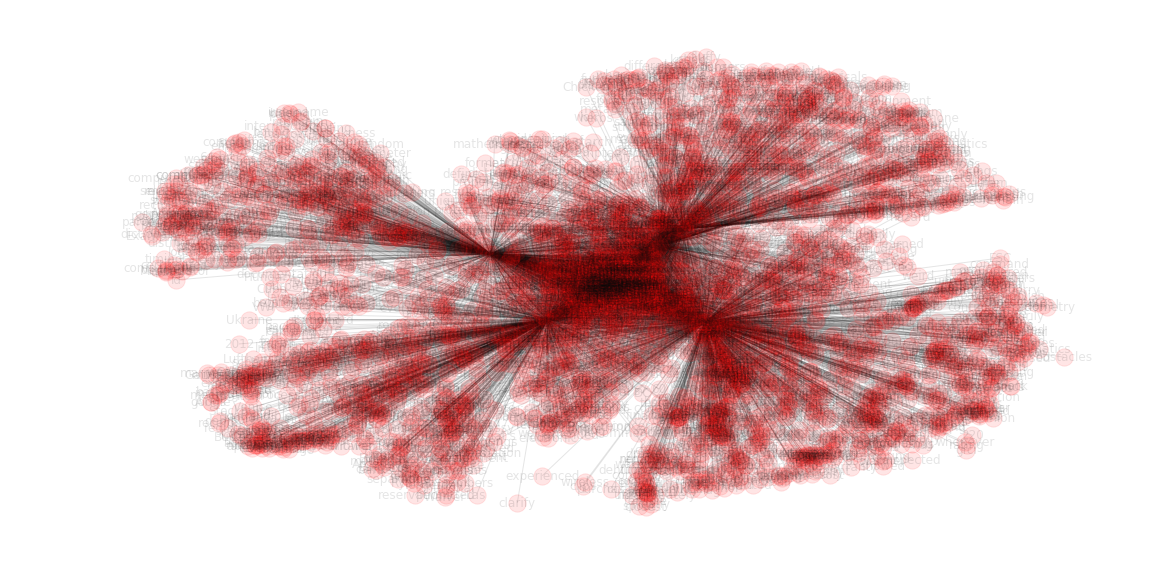

In [21]:
fig = plt.figure(figsize=[20,10])
nx.draw_networkx(g,alpha=0.1)
plt.axis('off')
fig.savefig('../figures/word_graph.jpg')

In [26]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor()
    ]),
}

In [27]:
dsets = {
    'train': TextDataset(subjects, path2data + 'train/',  transform = data_transforms['train'], is_train = True),
    'valid': TextDataset(subjects, path2data + 'train/',  transform = data_transforms['valid'], is_valid=True),
    'test':  TextDataset(subjects, path2data + 'test/',  transform = data_transforms['valid'], is_test=True),
}

In [28]:
dset_loaders = create_dataLoader(dsets, batch_size)

In [29]:
Net = Net(1000, 10)
print(Net)

Net (
  (fc1): Linear (1000 -> 128)
  (fc2): Linear (128 -> 32)
  (fc3): Linear (32 -> 10)
)


In [30]:
trainner = Trainner()